<a href="https://colab.research.google.com/github/caonhatlinhth/microsoft-stock-price-forecasting/blob/main/MS_Stock_Price_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
stock_price_csv = '/content/drive/My Drive/Colab Notebooks/Time Series/ms_stock_new.csv'

In [ ]:
with open(stock_price_csv, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

date,time,Open,High,Low,Close,Volume

First data point looks like this:

2015-04-01,16:00:00,40.6,40.76,40.31,40.72,36865322

Second data point looks like this:

2015-04-02,16:00:00,40.66,40.74,40.12,40.29,37487476



In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

**Parsing the data**

In [ ]:
# def parse_data_from_file(filename):

#     dates = []
#     stock_price = []

#     with open(filename) as csvfile:

#         reader = csv.reader(csvfile, delimiter=',')
#         next(reader)
#         for row in reader:
#             # Check if the row value at index 3 is not empty
#             if row[3]:
#                 stock_price.append(float(row[3]))
#             else:
#                 # Handle the missing data; you can skip, or append a default value
#                 # Here, appending the last known value or 0 if it's the first value
#                 stock_price.append(stock_price[-1] if stock_price else 0.0)
#         dates = [x for x in range(0, len(stock_price))]

#     return dates, stock_price

In [ ]:
def parse_data_from_file(filename):

    dates = []
    stock_price = []

    with open(filename) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            if row[3]:  # assuming column index 3 has stock prices
                dates.append(row[0])  # assuming column index 0 has the date values
                stock_price.append(float(row[5]))

    return dates, stock_price

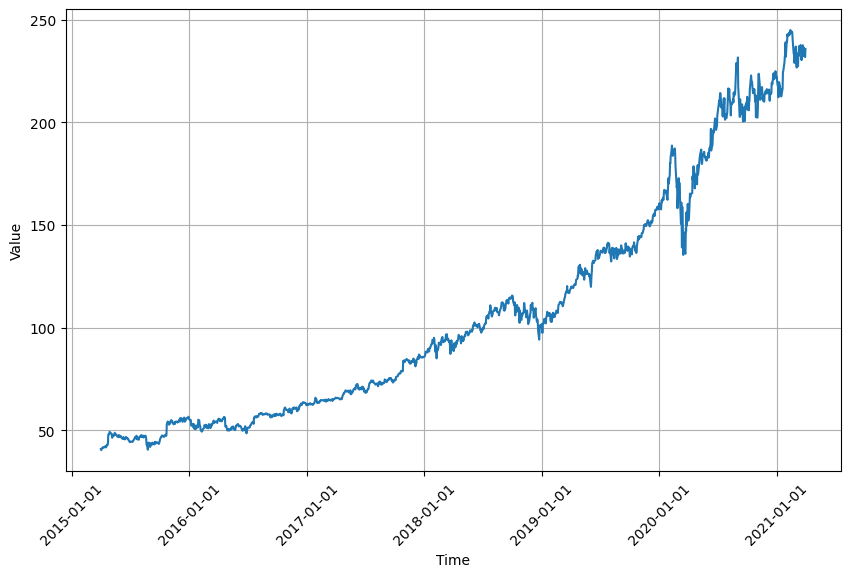

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates

@dataclass
class G:
  MS_STOCK_CSV = '/content/drive/My Drive/Colab Notebooks/Time Series/ms_stock_new.csv'
  dates, stock_price = parse_data_from_file(stock_price_csv)
  TIME = np.array(dates)
  SERIES = np.array(stock_price)
  SPLIT_TIME = 1198
  WINDOW_SIZE = 20
  BATCH_SIZE = 20
  SHUFFLE_BUFFER_SIZE = 800

scaler = MinMaxScaler()
scaled_stock_price = scaler.fit_transform(G.SERIES.reshape(-1, 1))

# Convert string dates into datetime objects
G.TIME = [mdates.datestr2num(date) for date in G.TIME]

plt.figure(figsize=(10,6))
plot_series(G.TIME, G.SERIES)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)  # rotate x-axis labels for better visibility
plt.show()

**Processing the data**

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
  time_train = time[:time_step]
  time_train = time[:time_step]
  series_train = series[:time_step]
  time_valid = time[time_step:]
  series_valid = series[time_step:]

  return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

**Define model architecture**

In [ ]:
# def create_uncompiled_model():

#     model = tf.keras.models.Sequential([
#       tf.keras.layers.Conv1D(filters=64, kernel_size=3,
#                       strides=1,
#                       activation="relu",
#                       padding='causal',
#                       input_shape=[None, 1]),
#       tf.keras.layers.LSTM(64, return_sequences=True),
#       tf.keras.layers.LSTM(64),
#       tf.keras.layers.Dense(30, activation="relu"),
#       tf.keras.layers.Dense(10, activation="relu"),
#       tf.keras.layers.Dense(1),
#       tf.keras.layers.Lambda(lambda x: x * 400)
#     ])

#     return model

In [ ]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                              input_shape = [None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    return model

**Adjust learning rate**

In [ ]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-8)

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [54]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
59/59 [==============================] - 12s 32ms/step - loss: 91.8877 - mae: 92.3875 - lr: 1.0000e-04
Epoch 2/100
59/59 [==============================] - 2s 40ms/step - loss: 24.5002 - mae: 24.9981 - lr: 1.1220e-04
Epoch 3/100
59/59 [==============================] - 3s 55ms/step - loss: 18.1334 - mae: 18.6289 - lr: 1.2589e-04
Epoch 4/100
59/59 [==============================] - 3s 48ms/step - loss: 6.9150 - mae: 7.3987 - lr: 1.4125e-04
Epoch 5/100
59/59 [==============================] - 2s 35ms/step - loss: 3.4326 - mae: 3.8952 - lr: 1.5849e-04
Epoch 6/100
59/59 [==============================] - 2s 33ms/step - loss: 1.6665 - mae: 2.1018 - lr: 1.7783e-04
Epoch 7/100
59/59 [==============================] - 2s 34ms/step - loss: 1.6223 - mae: 2.0636 - lr: 1.9953e-04
Epoch 8/100
59/59 [==============================] - 4s 60ms/step - loss: 1.7347 - mae: 2.1769 - lr: 2.2387e-04
Epoch 9/100
59/59 [==============================] - 4s 57ms/step - loss: 1.5080 - mae: 1.9457 - 

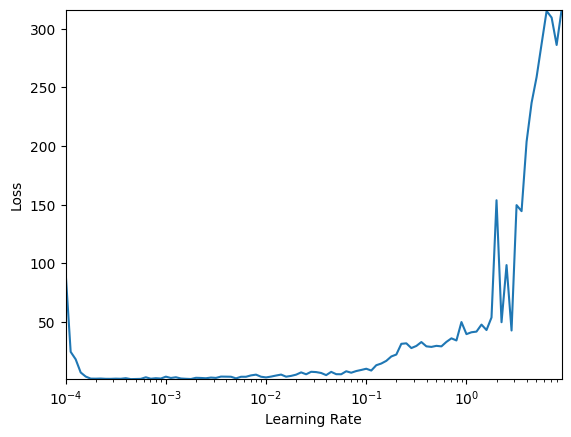

In [55]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([min(lr_history.history["lr"]), max(lr_history.history["lr"]), min(lr_history.history["loss"]), max(lr_history.history["loss"])])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

**Compiling the model**

In [56]:
def create_model():
  model = create_uncompiled_model()

  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=["mae"])

  return model

In [57]:
model = create_model()
history = model.fit(train_set, epochs=50)

Epoch 1/50
59/59 [==============================] - 13s 44ms/step - loss: 17.9972 - mae: 18.4866
Epoch 2/50
59/59 [==============================] - 2s 35ms/step - loss: 3.3704 - mae: 3.8376
Epoch 3/50
59/59 [==============================] - 2s 35ms/step - loss: 2.3755 - mae: 2.8354
Epoch 4/50
59/59 [==============================] - 2s 32ms/step - loss: 2.2220 - mae: 2.6802
Epoch 5/50
59/59 [==============================] - 3s 42ms/step - loss: 1.6631 - mae: 2.1089
Epoch 6/50
59/59 [==============================] - 4s 59ms/step - loss: 1.7987 - mae: 2.2391
Epoch 7/50
59/59 [==============================] - 2s 34ms/step - loss: 1.6823 - mae: 2.1273
Epoch 8/50
59/59 [==============================] - 2s 38ms/step - loss: 2.0453 - mae: 2.4950
Epoch 9/50
59/59 [==============================] - 3s 53ms/step - loss: 1.2271 - mae: 1.6540
Epoch 10/50
59/59 [==============================] - 2s 37ms/step - loss: 1.5151 - mae: 1.9552
Epoch 11/50
59/59 [==============================] - 4s 

**Faster model forecast**

In [58]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [59]:
from datetime import datetime

# Example: Assuming time_valid contains timestamps in seconds since epoch
time_valid_datetime = [datetime.fromtimestamp(t) for t in time_valid]


47/47 [==============================] - 3s 21ms/step


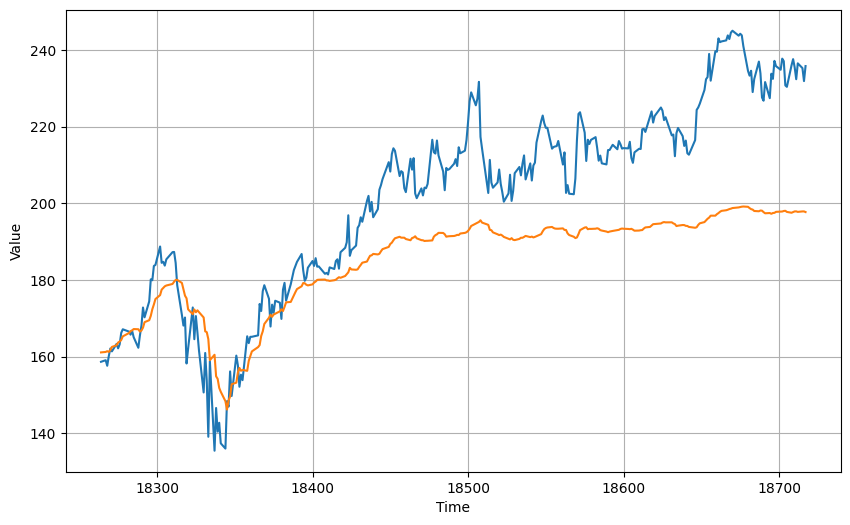

In [60]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [61]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [62]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 459.22, mae: 17.61 for forecast
